# Machine Learning Potentials and Molecular Dynamics Simulations for Materials Science

## Introduction: Empirical Potentials and Molecular Dynamics

Molecular dynamics (MD) simulations are a cornerstone of computational materials science, enabling us to model the time evolution of atoms based on classical mechanics. The trajectory of each atom is computed by solving Newton's equations of motion:

$$
F = m\, a,
$$
where the force is given by the gradient of the potential energy, $U$, with respect to the coordinate, $\vec r_i$ of each atom $i$.

Hence,
$$
-\nabla_{\mathbf{r}_i} U(\mathbf{r}_1, \dots, \mathbf{r}_N) = m_i \frac{d^2\mathbf{r}_i}{dt^2}
$$

### A Brief History of Potentials

- **1930s–1960s**: Early MD simulations used hard-sphere or Lennard-Jones (LJ) potentials.
- **1970s–1980s**: Development of many-body potentials like **Embedded Atom Method (EAM)** and **Tersoff**.
- **1990s–2010s**: Reactive force fields (ReaxFF) and tight-binding approaches added chemical reactivity.
- **2020s–now**: Machine learning potentials (MLPs) like **GAP**, **NequIP**, and **UF3** offer near-quantum mechanical accuracy.

### Why Machine Learning Potentials?

Machine-learned interatomic potentials interpolate the quantum mechanical potential energy surface (described by density functional theory or DFT) using high-dimensional, non-linear functions:
- The goal is for the accuracy of MLIPs to approach that of DFT while being as fast like empirical force fields.
- Applicable to large-scale MD for melting, diffusion, and phase transitions.

In this notebook, we train a UF3 model for tungsten and use it to simulate melting with LAMMPS.

In [1]:
import os
from concurrent.futures import ProcessPoolExecutor

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Uncomment and run if not already installed

# Install UF3
#!pip install git+https://github.com/uf3/uf3.git@monk-04-patch-3

# Install LAMMPS with UF3 support

In [4]:
from uf3.data import io
from uf3.data import geometry
from uf3.data import composition
from uf3.representation import bspline
from uf3.representation import process
from uf3.regression import least_squares
from uf3.forcefield import calculator
from uf3.forcefield import lammps
from uf3.util import parallel
from uf3.util import plotting
from uf3.util import plotting3d
from uf3.util import plot_slices_3b

/Users/rhennig/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# $\text{UF}_{2,3}$ Demo: Elemental tungsten

**Data split**
- Training set: 1939 configurations (stratified 20% of the dataset)

- Holdout: 7754 configurations (remaining 80%)

**Inputs**
- ```w-14.xyz``` (30 mb)
- ```training_idx.txt``` (10 kb, included for reproducibility purposes)

**Outputs**
- ```df_features_uf23.h5``` (650 mb)
- ```model_uf23.json``` (3 kb)

In [5]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

 Step         | Estimated Time 
:-------------|:--------------
Preprocessing | 10 seconds
Featurization | 30 core-minutes (parallelizable)
Training      | 4 seconds
Prediction    | 3 seconds
Plotting      | 5 seconds

# User Parameters

```element_list (list)```: list of element symbols

```degree (int)```: truncation of many-body expansion. A value of 3 yields a two-and-three-body potential.

In [6]:
element_list = ['W']
degree = 3

Initialize the ```ChemicalSystem``` and inspect interactions.

Elements involved in each interactions are sorted by electronegativity.

In [7]:
chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)
print(chemical_system)

ChemicalSystem:
    Elements: ('W',)
    Degree: 3
    Pairs: [('W', 'W')]
    Trios: [('W', 'W', 'W')]


In [8]:
print("Trios:", chemical_system.interactions_map[3])

Trios: [('W', 'W', 'W')]


# Selecting cutoffs

```r_min_map (dict)```: map of minimum pair distance per interaction (angstroms). 
    If unspecified, defaults to 1.0 for all interactions.
    
```r_max_map (dict)```: map of maximum pair distance per interaction (angstroms). 
    If unspecified, defaults to 6.0 angstroms for all interactions, which probably encompasses at least 2nd-nearest neighbors.
    
```resolution_map (dict)```: map of resolution (number of knot intervals) per interaction. 
    For the cubic basis, the number of basis functions equals three more than the number of knot intervals.
    This is, in turn, negated by ```trailing_trim```.
    If unspecified, defaults to 20 for all two-body interactions and 5 for three-body interactions.
    
```trailing_trim (int)```: number of trailing basis functions to trim, defaults to 3.
 - ```= 0```: hard cutoff at ```r_max```
 - ```= 1```: function goes to zero at ```r_max```
 - ```= 2```: first derivative goes to zero at ```r_max```
 - ```= 3```: second derivative goes to zero at ```r_max```
 
```leading_trim (int)```: similar for leading basis functions (small distances), defaults to 0 for 2-body and 3 for 3-body

**Note: the demo's resolution and cutoffs (3.5-3.5-7.0Å, 6-6-12) are small to reduce runtime and filesize.**

**Results in the manuscript use (4.25-4.25-8.5Å, 10-10-20), requiring about 20 core-minutes and 6 gb.**

## Sensible values can be chosen based on the results from the two-body demo.
**r_min and r_max should span the region near the two-body potential minimum
and any inflection points.**

**High values for r_max increase the size of neighbor lists and slows down calculations.
Sensible values for r_max for the two-body terms can be quickly estimated
through grid-search in the two-body demo.**

**r_max for the three-body can be slightly lower based on the assumption that
higher-order terms are most important for nearest neighbors.**

In [9]:
r_min_map = {("W", "W"): 0.001,
             ("W", "W", "W"): [1.0, 1.0, 1.0],
            }
r_max_map = {("W", "W"): 5.5,
             ("W", "W", "W"): [3.5, 3.5, 7.0],
            }
resolution_map = {("W", "W"): 15,
                  ("W", "W", "W"): [9, 9, 12],
                 }
#trailing_trim = {2: 3, 3: 3}  # 3 for 2-body, 3 for 3-body
#leading_trim = {2: 0, 3: 3}  # 0 for 2-body, 3 for 3-body

trailing_trim = 3  # 3 for 2-body, 3 for 3-body
leading_trim =  0  # 0 for 2-body, 3 for 3-body

# Integer values are also accepted for the trim parameters, in which case the
# same value is used for both 2-body and 3-body.

# Demo parameters
```n_cores```: number of workers to use in parallel for feature generation

```data_filename```: filename of reference data including geometries, energies, forces, ...

```filename```: filename to save features dataframe.

```table_template```: format string for table names in feature dataframe.

In [10]:
n_cores = os.cpu_count()
print("Number of cores:", n_cores)

Number of cores: 12


In [11]:
example_directory = os.getcwd()
data_filename = os.path.join(example_directory, "w-14.xyz")

In [12]:
filename = "df_features.h5"
table_template = "features_{}"

# Initialize basis

In [13]:
bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      leading_trim=leading_trim,
                                      trailing_trim=trailing_trim)

```bspline_config.get_interaction_partitions()``` yields the number of coefficients for each n-body interaction (one-body terms, two-body terms, three-body terms, ...) as well as the starting index in the coefficient vector for each interaction.

In [14]:
bspline_config.get_interaction_partitions()[0]

{'W': 1, ('W', 'W'): 18, ('W', 'W', 'W'): 475}

In [15]:
bspline_config.get_interaction_partitions()[1]

{'W': 0, ('W', 'W'): 1, ('W', 'W', 'W'): 19}

# Load data

In [16]:
data_coordinator = io.DataCoordinator()
data_coordinator.dataframe_from_trajectory(data_filename,
                                           prefix='dft')
df_data = data_coordinator.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))

Number of energies: 9693
Number of forces: 475578


In [17]:
df_data.head()

,geometry,energy,fx,fy,fz,size
dft_0,"(Atom('W', [-0.11884125, 0.56601359, -0.509794...",-130.513933,"[1.54793448, 0.58999959, -0.58709714, -1.33024...","[-1.57652002, -0.28567366, 1.3652337, -1.22802...","[0.99819291, 2.27980784, -2.04203536, 0.359781...",12.0
dft_1,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.043949,0.0,0.0,0.0,1.0
dft_2,"(Atom('W', [0.09315869, 0.19816107, 0.69741018...",-129.297259,"[-1.81167217, 0.86343948, 1.97934756, -3.56781...","[-1.46312022, -1.544852, 1.96424059, -0.422026...","[-2.0347835, 4.9423454, -2.59181614, -4.624641...",12.0
dft_3,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.103674,0.0,0.0,0.0,1.0
dft_4,"(Atom('W', [1.54699185, 1.52327932, 1.64033917...",-588.094930,"[0.69935022, -0.85135631, 0.63290532, -0.68801...","[0.50860704, -0.28415883, 0.98954505, 0.740742...","[-1.17745423, -0.15499728, 0.30238667, -1.0709...",53.0


In [18]:
# Remove all the data of size 1 as they copntain no forces and this results in an error in the current UF3 implementation
df_data = df_data[df_data["size"] > 1]
df_data = df_data.reset_index(drop=True)
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))
df_data.tail()

Number of energies: 7693
Number of forces: 469578


,geometry,energy,fx,fy,fz,size
7688,"(Atom('W', [0.0, 0.0, 0.0], index=0), Atom('W'...",-133.755879,"[0.7860931, 0.02775523, 0.02610957, 0.78609149...","[-1.10238385, 0.02902203, 0.02951105, -1.09992...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12.0
7689,"(Atom('W', [0.10112196, -0.1040489, 0.26589744...",-125.516996,"[-0.66175533, 0.43412215, -2.35121451, -2.6757...","[1.47586898, 1.69863814, -2.2716413, -1.366293...","[-2.2868445, 3.84249323, 3.53447983, -2.592980...",12.0
7690,"(Atom('W', [0.02096101, -0.0289228, -0.0177463...",-129.978503,"[-2.35713226, 1.74285784, 3.73546204, -0.68190...","[-2.18389431, 0.7050167, 0.26206762, 2.6067750...","[2.05704733, -1.35419125, -1.39598657, 1.89703...",12.0
7691,"(Atom('W', [-0.15255733, 2.97762113, 0.7856076...",-1495.810852,"[0.66799298, 0.0332613, -0.1608068, 0.67553654...","[0.01171158, 0.55581768, -0.16421142, 0.210567...","[0.64515088, -0.18783926, 0.14076626, 0.111696...",135.0
7692,"(Atom('W', [0.09567731, 0.27316592, 0.01623395...",-129.692301,"[-0.45050582, -0.2351222, -2.56658392, -0.7089...","[-2.05114318, 1.07563273, -0.1837682, 2.972754...","[0.09315809, -0.5900123, -0.87189353, 0.480698...",12.0


# Examine pair distance distribution
Useful step that serves as a sanity check for selected cutoffs and resolution.

In [19]:
from uf3.data import analyze
from tqdm.auto import tqdm

In [20]:
analyzer = analyze.DataAnalyzer(chemical_system, 
                                r_cut=10.0,
                                bins=0.01)

In [21]:
atoms_key = data_coordinator.atoms_key
histogram_slice = np.random.choice(np.arange(len(df_data)),
                                   min(1000, len(df_data)),
                                   replace=False)
df_slice = df_data[atoms_key].iloc[histogram_slice]
analyzer.load_entries(df_slice)

100%|██████████| 1000/1000 [00:05<00:00, 197.08it/s]


In [22]:
analysis = analyzer.analyze()

    Smallest observed: 1.93 angstroms
    Suggested Cutoffs: [3.16  3.21  3.37  3.57  3.685 3.79  3.965 4.265 4.47  4.52  4.885 5.25
 5.3   5.38  5.445 5.48  5.53  5.565 5.67  5.855 6.13  6.34  6.39  6.425
 6.68  6.995 7.085 7.135 7.455 7.77  7.82  8.05  8.41  8.655 8.845 8.97
 9.02  9.06  9.215 9.38  9.43  9.475 9.51  9.56  9.695]


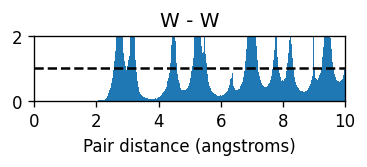

In [23]:
canvases = plotting.plot_pair_distributions(analysis, show_cutoffs=False, figsize=(3.5, 1.5))
for fig, ax in canvases:
    fig.set_dpi(120)
    fig.tight_layout()
    ax.set_ylabel("")
    # fig.show()

# Compute energy and force features



In [24]:
representation = process.BasisFeaturizer(bspline_config)

In [25]:
client = ProcessPoolExecutor(max_workers=n_cores)

In [26]:
representation.batched_to_hdf(filename,
                              df_data,
                              client,
                              n_jobs = n_cores,
                              batch_size=50,
                              progress="bar",
                              table_template=table_template)

  0%|          | 0/154 [00:00<?, ?it/s]/Users/rhennig/miniconda3/lib/python3.12/site-packages/uf3/representation/process.py:547: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  dataframe.to_hdf(filename, table_name, mode="a", format='fixed')
  1%|          | 1/154 [00:02<07:27,  2.93s/it]/Users/rhennig/miniconda3/lib/python3.12/site-packages/uf3/representation/process.py:547: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  dataframe.to_hdf(filename, table_name, mode="a", format='fixed')
  1%|▏         | 2/154 [00:03<04:00,  1.58s/it]/Users/rhennig/miniconda3/lib/python3.12/site-packages/uf3/representation/process.py:547: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  dataframe.to_hdf(filename, table_name, mode="a", format='fixed')


# Fit model

### Split data into training and testing set

In [27]:
# create training and test index using a random split

train_index = np.random.choice(df_data.index, size=int(len(df_data) * 0.8), replace=False)
test_index = np.array(list(set(df_data.index) - set(train_index)))
train_index = np.sort(train_index)
test_index = np.sort(test_index)
print("Number of training points:", len(train_index))
print("Number of test points:", len(test_index))
print("Number of training forces:", int(np.sum(df_data.loc[train_index]["size"]) * 3))
print("Number of test forces:", int(np.sum(df_data.loc[test_index]["size"]) * 3))

Number of training points: 6154
Number of test points: 1539
Number of training forces: 372798
Number of test forces: 96780


### Regularized linear regression

In [28]:
regularizer = bspline_config.get_regularization_matrix(ridge_1b=0.0,
                                                       ridge_2b=0.0,
                                                       ridge_3b=1e-8,
                                                       curvature_2b=1e-8,
                                                       curvature_3b=0.0)

model = least_squares.WeightedLinearModel(bspline_config,
                                          regularizer=regularizer)

# Fit with energies and force

Train with the training index that includes 80% of the dataset

In [29]:
model.fit_from_file(filename, 
                    df_data.index[train_index],
                    weight=0.8, 
                    batch_size=2500,
                    energy_key="energy", 
                    progress="bar")

100%|██████████| 154/154 [00:04<00:00, 36.70it/s]


('W', 'W') Correction: adjusted 5 coefficients.


(-0.8, 0.8)

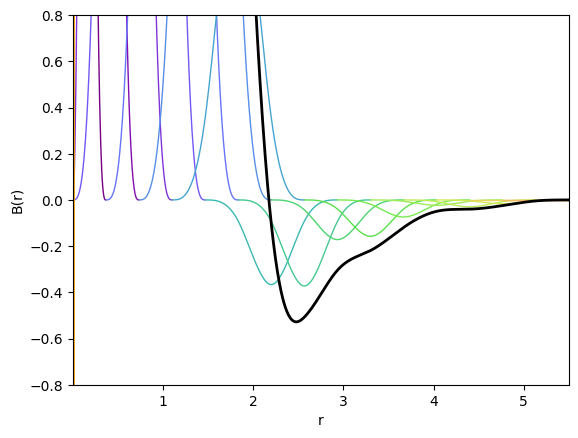

In [30]:
pair = ("W", "W")

r_target = analysis["lower_bounds"][pair]
model.fix_repulsion_2b(pair, 
                       r_target=r_target,
                       min_curvature=0.0)

solutions = least_squares.arrange_coefficients(model.coefficients,
                                               bspline_config)
coefficients = solutions[("W", "W")]
knot_sequence = bspline_config.knots_map[("W", "W")]
fig, ax = plotting.visualize_splines(coefficients, knot_sequence)
plt.vlines([0.0], -100, 100, color="orange", linewidth=2)
ax.set_ylim(-0.8, 0.8)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x

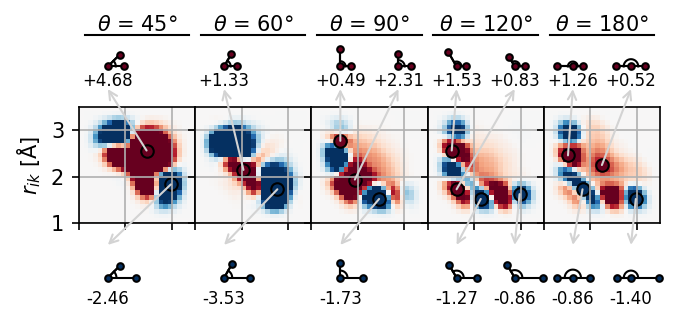

In [31]:
fig, gs = plot_slices_3b.plot_slices(model, ('W','W','W'),
                                     thetas=(45, 60, 90, 120, 180),
                                     vmin=-0.6, vmax=0.6)

In [32]:
tbp = plotting3d.ThreeBodyPlotter(model, ("W", "W", "W"))
tbp.sample_uniformly(20)
tbp.plot_uniform(val_limit=0.1)

1.0 7.0


# Prediction

In [33]:
y_e, p_e, y_f, p_f, rmse_e, rmse_f = model.batched_predict(filename, 
                                                           keys=test_index)

RMSE (energy): 0.012
RMSE (forces): 0.182


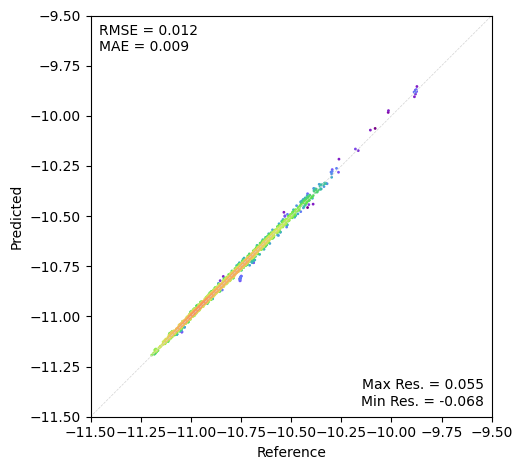

In [34]:
plotting.density_scatter(y_e, p_e)
plt.tight_layout()

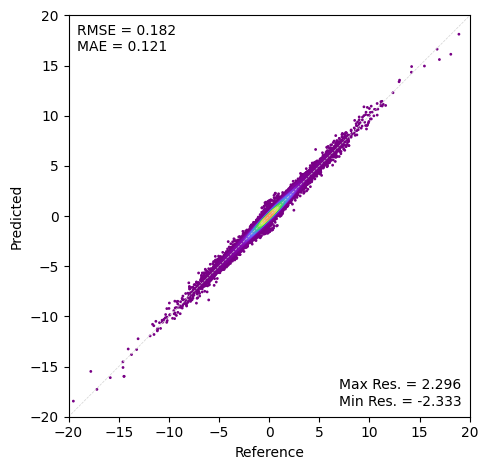

In [35]:
plotting.density_scatter(y_f, p_f)
plt.tight_layout()

## Export UF3 potential for LAMMPS

In [36]:
# Save model in json file
model.to_json("tungsten.json")

# Call Python code "generate_uf3_lammps_pots.py" to generate the LAMMPS potential files

!python generate_uf3_lammps_pots.py \
    --author AI4Materials \
    --units metal \
    --model tungsten.json \
    --directory ./ \
    --knots_spacing_type nk

# Replace "{2: 0, 3: 0} {2: 3, 3: 3}"" in lines 6 and 9 with "0 3" in file W.uf3
import re
with open('W.uf3', 'r') as f:
    content = f.read()

# Replace all occurrences of the exact pattern
content = re.sub(r"\{2: 0, 3: 0\} \{2: 3, 3: 3\}", "0 3", content)

with open('W.uf3', 'w') as f:
    f.write(content)



***Add the following line to the lammps input script***


pair_style	uf3 3 1
pair_coeff	* * .//W.uf3 W


Citation meta-data has been left blank. Please enter appropriatei citation for the generated UF3 LAMMPS potential




## Perform molecular dynamics simulation using LAMMPS

### Installing LAMMPS with ML-UF3 in a Miniconda Environment

This guide explains how to build and run LAMMPS with the `ML-UF3` package enabled inside an existing **Miniconda environment**. This is ideal for users who already manage Python ML tools via Conda and want to extend their workflows to LAMMPS simulations.

---

#### Step 1: Activate Your Miniconda Environment

Open your terminal or VS Code integrated terminal and activate your existing environment:

- conda activate your-env-name

---
#### Step 2: Install Build Tools and Compilers

Install the necessary packages from conda-forge:
- conda install -c conda-forge cmake make
- conda install -c conda-forge compilers
- conda install -c conda-forge fftw blas

These provide:
- cmake – build system
- make – build tool
- gcc, g++, gfortran – C/C++/Fortran compilers
- FFT and BLAS libraries for performance

---
#### Step 3: Clone and Build LAMMPS with ML-UF3
- git clone https://github.com/lammps/lammps.git
- cd lammps
- mkdir build && cd build

Now configure with CMake, ensuring that ML-UF3 is enabled:
- cmake ../cmake \
  -D CMAKE_INSTALL_PREFIX=$HOME/lammps-conda \
  -D CMAKE_PREFIX_PATH=$CONDA_PREFIX \
  -D BUILD_MPI=OFF \
  -D BUILD_SHARED_LIBS=OFF \
  -D PKG_ML-UF3=ON \
  -D PKG_USER-MLIAP=ON \
  -D PKG_ML-SNAP=OFF \
  -D PKG_ML-IAP=OFF

Then build and install:
- make -j$(nproc)
- make install

Verify that LAMMPS was built with UF3 support:
- $HOME/lammps-conda/bin/lmp -h | grep ML-UF3

In [37]:
# Create BCC tungsten 5x5x5 supercell
# Experimental Lattice constant for BCC tungsten in angstroms
a0 = 3.165

def create_bcc_supercell(a0, nx, ny, nz):
    # Basis atoms for BCC unit cell
    basis = np.array([
        [0.0, 0.0, 0.0],
        [0.5, 0.5, 0.5]
    ])

    positions = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                for atom in basis:
                    pos = a0 * (atom + [i, j, k])
                    positions.append(pos)
    return np.array(positions)

positions = create_bcc_supercell(a0, 5, 5, 5)
n_atoms = len(positions)
print(f"Generated {n_atoms} atoms.")

Generated 250 atoms.


In [38]:
def write_lammps_data(filename, positions, a0, nx, ny, nz):
    with open(filename, "w") as f:
        f.write("LAMMPS data file for BCC tungsten 5x5x5 supercell\n\n")
        f.write(f"{len(positions)} atoms\n")
        f.write("1 atom types\n\n")

        lx = nx * a0
        ly = ny * a0
        lz = nz * a0
        f.write(f"0.0 {lx:.6f} xlo xhi\n")
        f.write(f"0.0 {ly:.6f} ylo yhi\n")
        f.write(f"0.0 {lz:.6f} zlo zhi\n\n")

        f.write("Masses\n\n")
        f.write("1 183.84\n\n")  # Atomic mass of W

        f.write("Atoms\n\n")
        for i, pos in enumerate(positions, start=1):
            f.write(f"{i} 1 {pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")

write_lammps_data("tungsten.data", positions, a0, 5, 5, 5)
print("LAMMPS data file written to 'tungsten.data'")

LAMMPS data file written to 'tungsten.data'


In [39]:
# Create LAMMPS input file for melting test            
with open("melting_test.in", "w") as f:
    f.write("""units metal
atom_style atomic
read_data tungsten.data

pair_style	uf3 3
pair_coeff	* * ./W.uf3 W
            
# Define thermo output
thermo          100
thermo_style    custom step temp pe etotal press vol

# Minimization (relax atoms and box)
reset_timestep  0
fix 1 all box/relax iso 0.0 vmax 0.001
min_style       cg
minimize        1.0e-10 1.0e-10 10000 100000
unfix           1

# Equilibration at 3000 K
velocity        all create 6000.0 12345 mom yes rot no dist gaussian
fix             equil all npt temp 3000.0 3000.0 0.1 iso 0.0 0.0 1.0
run             2000
unfix           equil

# Temperature ramp from 3000K to 5000K
timestep        0.001

# Write atomic positions every 100 steps
dump            1 all custom 100 dump.relax_heat.lammpstrj id type x y z
dump_modify     1 sort id
            
fix             2 all npt temp 3000 5000.0 0.1 iso 0.0 0.0 1.0
run             50000
unfix           2
                       
""")

# Running LAMMPS
!~/lammps-install/bin/lmp -in melting_test.in


LAMMPS (2 Apr 2025 - Development - patch_2Apr2025-112-gb081d289c1-modified)
Reading data file ...
  orthogonal box = (0 0 0) to (15.825 15.825 15.825)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  250 atoms
  read_data CPU = 0.001 seconds
Reading potential file ./W.uf3 with DATE: 2025-04-17
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.5
  ghost atom cutoff = 7.5
  binsize = 3.75, bins = 5 5 5
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair uf3, perpetual
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
Setting up cg style minimization ...
  Unit style    : metal
  Current step  : 0
 (src/min.cpp:219)
Per MPI rank memory allocation (min/avg/max) = 4.375 | 4.375 | 4.375 Mbytes
   Step          Temp          PotEng         TotEng         Press          Volume    
         0   0      

    Step       Temp        Epot        Etot       Press     Volume  Time
0  10200  3381.1653   -1044.825  -935.99955   8125.5144  4151.3155  10.2
1  10300  3233.2491  -1038.2807  -934.21611   15202.452  4150.1842  10.3
2  10400  3419.7396  -1037.6007  -927.53377  -17112.691  4197.0366  10.4
3  10500  3491.9037  -1030.5417  -918.15211  -1490.6865  4186.9432  10.5
4  10600  3350.7483  -1026.1991  -918.35265   23203.234  4163.2199  10.6
0       -1044.825
1      -1038.2807
2      -1037.6007
3      -1030.5417
4      -1026.1991
          ...    
415    -804.62919
416    -792.75159
417    -785.64939
418    -786.47661
419    -786.22463
Name: Epot, Length: 420, dtype: object


/var/folders/bs/0gq1hs_s5dj8v_l72shwbx85g41yw6/T/ipykernel_46653/1154524342.py:7: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



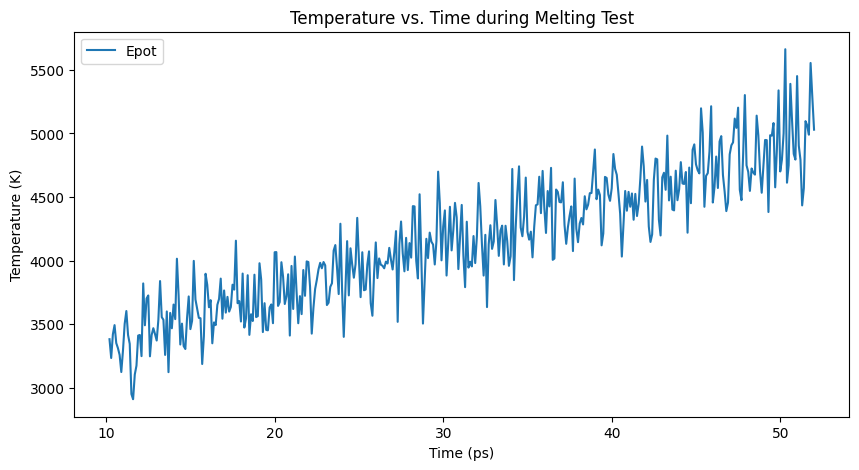

In [40]:
# Read the LAMMPS log file and plot the temperature vs. time
import pandas as pd

log_file = "log.lammps"

# Skip to section "Temperature ramp"
lammps_data = pd.read_csv(log_file, delim_whitespace=True, skiprows=230, on_bad_lines="skip")
lammps_data.columns = ["Step", "Temp", "Epot", "Etot", "Press", "Volume"]
lammps_data = lammps_data.dropna()
lammps_data["Temp"] = pd.to_numeric(lammps_data["Temp"], errors='coerce')
lammps_data = lammps_data.dropna()
lammps_data["Step"] = pd.to_numeric(lammps_data["Step"], errors='coerce')
lammps_data = lammps_data.dropna()
lammps_data["Time"] = lammps_data["Step"] * 0.001  # Convert to ps

print(lammps_data.head())
print(lammps_data["Epot"])

plt.figure(figsize=(10, 5))

plt.plot(lammps_data["Time"], lammps_data["Temp"], label="Epot")

plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Temperature vs. Time during Melting Test")
plt.legend()

plt.show()


### Assignment

> Which calculated parameter may help us identify the melting of the materials?
>
> Select one and create a plot of its dependence on temperature.
>
> What is the predicted melting point and how does it compare to the experimental value?
>
> What could be the reason for any discrepancy?